<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:08:59] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


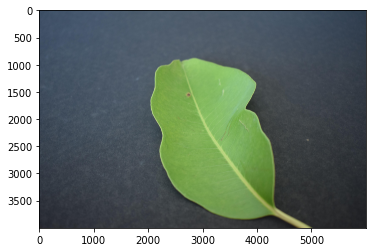

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

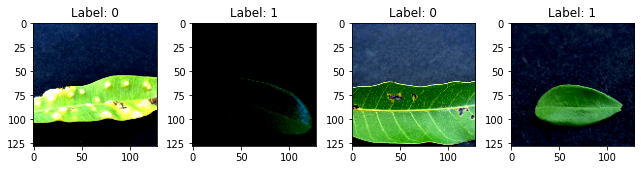

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:09:05] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:09:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.203970431951932 samples/sec                   batch loss = 0.6250247359275818 | accuracy = 0.8


Epoch[1] Batch[10] Speed: 1.2621439258873692 samples/sec                   batch loss = 0.900050699710846 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2680443632197043 samples/sec                   batch loss = 0.6670369505882263 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2669115831395774 samples/sec                   batch loss = 0.4174565076828003 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.269099485770565 samples/sec                   batch loss = 0.487367182970047 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2700342542231104 samples/sec                   batch loss = 0.6065770983695984 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2673625374662956 samples/sec                   batch loss = 0.7371160387992859 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.263840883298675 samples/sec                   batch loss = 0.7901846766471863 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2649640752415103 samples/sec                   batch loss = 1.08158278465271 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.2689822805398774 samples/sec                   batch loss = 1.918260097503662 | accuracy = 0.55


Epoch[1] Batch[55] Speed: 1.2702811936446325 samples/sec                   batch loss = 0.6235753297805786 | accuracy = 0.55


Epoch[1] Batch[60] Speed: 1.2701263644768315 samples/sec                   batch loss = 0.2769625782966614 | accuracy = 0.55


Epoch[1] Batch[65] Speed: 1.2710484912734255 samples/sec                   batch loss = 0.3779407739639282 | accuracy = 0.5615384615384615


Epoch[1] Batch[70] Speed: 1.2713226063285847 samples/sec                   batch loss = 1.319305658340454 | accuracy = 0.5571428571428572


Epoch[1] Batch[75] Speed: 1.2705768202120973 samples/sec                   batch loss = 0.4805651009082794 | accuracy = 0.57


Epoch[1] Batch[80] Speed: 1.2643811232898536 samples/sec                   batch loss = 0.28196367621421814 | accuracy = 0.56875


Epoch[1] Batch[85] Speed: 1.2643042309222663 samples/sec                   batch loss = 0.5205652713775635 | accuracy = 0.5647058823529412


Epoch[1] Batch[90] Speed: 1.2603972608029386 samples/sec                   batch loss = 0.4803020656108856 | accuracy = 0.5638888888888889


Epoch[1] Batch[95] Speed: 1.2638324100100686 samples/sec                   batch loss = 0.4328498840332031 | accuracy = 0.5684210526315789


Epoch[1] Batch[100] Speed: 1.2700944416652837 samples/sec                   batch loss = 0.5767911672592163 | accuracy = 0.5625


Epoch[1] Batch[105] Speed: 1.2715390153274677 samples/sec                   batch loss = 0.6038379073143005 | accuracy = 0.5761904761904761


Epoch[1] Batch[110] Speed: 1.2710055450946613 samples/sec                   batch loss = 0.39836806058883667 | accuracy = 0.575


Epoch[1] Batch[115] Speed: 1.2723255873917245 samples/sec                   batch loss = 0.6564211845397949 | accuracy = 0.5760869565217391


Epoch[1] Batch[120] Speed: 1.2750126724459607 samples/sec                   batch loss = 0.5168454051017761 | accuracy = 0.5791666666666667


Epoch[1] Batch[125] Speed: 1.274096300907948 samples/sec                   batch loss = 0.5819439888000488 | accuracy = 0.58


Epoch[1] Batch[130] Speed: 1.2710010195453 samples/sec                   batch loss = 1.0397117137908936 | accuracy = 0.5769230769230769


Epoch[1] Batch[135] Speed: 1.278218206417126 samples/sec                   batch loss = 0.9489434361457825 | accuracy = 0.5796296296296296


Epoch[1] Batch[140] Speed: 1.2713428373518247 samples/sec                   batch loss = 1.0027399063110352 | accuracy = 0.5875


Epoch[1] Batch[145] Speed: 1.2725886700789029 samples/sec                   batch loss = 0.6963068842887878 | accuracy = 0.5862068965517241


Epoch[1] Batch[150] Speed: 1.270378149383401 samples/sec                   batch loss = 0.4579751491546631 | accuracy = 0.59


Epoch[1] Batch[155] Speed: 1.2731697481399569 samples/sec                   batch loss = 0.40587425231933594 | accuracy = 0.5838709677419355


Epoch[1] Batch[160] Speed: 1.2671950190820782 samples/sec                   batch loss = 1.3147212266921997 | accuracy = 0.58125


Epoch[1] Batch[165] Speed: 1.2655572068696612 samples/sec                   batch loss = 0.6217505931854248 | accuracy = 0.5848484848484848


Epoch[1] Batch[170] Speed: 1.2681998355450892 samples/sec                   batch loss = 0.4690304398536682 | accuracy = 0.5882352941176471


Epoch[1] Batch[175] Speed: 1.277736918444695 samples/sec                   batch loss = 1.2374695539474487 | accuracy = 0.5885714285714285


Epoch[1] Batch[180] Speed: 1.262482420702308 samples/sec                   batch loss = 0.6282402276992798 | accuracy = 0.5916666666666667


Epoch[1] Batch[185] Speed: 1.270938531743624 samples/sec                   batch loss = 0.5691962242126465 | accuracy = 0.5945945945945946


Epoch[1] Batch[190] Speed: 1.275099497825359 samples/sec                   batch loss = 0.5488244891166687 | accuracy = 0.5960526315789474


Epoch[1] Batch[195] Speed: 1.2725027653843657 samples/sec                   batch loss = 0.6930176019668579 | accuracy = 0.6025641025641025


Epoch[1] Batch[200] Speed: 1.2786729592693373 samples/sec                   batch loss = 0.3954404592514038 | accuracy = 0.6075


Epoch[1] Batch[205] Speed: 1.270124825991278 samples/sec                   batch loss = 1.010302186012268 | accuracy = 0.6036585365853658


Epoch[1] Batch[210] Speed: 1.2719874842349352 samples/sec                   batch loss = 0.5000500082969666 | accuracy = 0.6035714285714285


Epoch[1] Batch[215] Speed: 1.2675693640959045 samples/sec                   batch loss = 0.29908108711242676 | accuracy = 0.608139534883721


Epoch[1] Batch[220] Speed: 1.2696501888974807 samples/sec                   batch loss = 0.70460444688797 | accuracy = 0.6090909090909091


Epoch[1] Batch[225] Speed: 1.268607484347527 samples/sec                   batch loss = 0.6255428791046143 | accuracy = 0.6144444444444445


Epoch[1] Batch[230] Speed: 1.2672021975331078 samples/sec                   batch loss = 0.8397152423858643 | accuracy = 0.6141304347826086


Epoch[1] Batch[235] Speed: 1.2706114616811859 samples/sec                   batch loss = 0.48417970538139343 | accuracy = 0.6148936170212767


Epoch[1] Batch[240] Speed: 1.2741344245014634 samples/sec                   batch loss = 0.2841609716415405 | accuracy = 0.6166666666666667


Epoch[1] Batch[245] Speed: 1.2685812012705158 samples/sec                   batch loss = 0.4688224792480469 | accuracy = 0.6224489795918368


Epoch[1] Batch[250] Speed: 1.2725460058483116 samples/sec                   batch loss = 0.7303622364997864 | accuracy = 0.624


Epoch[1] Batch[255] Speed: 1.2740703704271852 samples/sec                   batch loss = 1.0269694328308105 | accuracy = 0.6215686274509804


Epoch[1] Batch[260] Speed: 1.2694188622757663 samples/sec                   batch loss = 0.8231525421142578 | accuracy = 0.6201923076923077


Epoch[1] Batch[265] Speed: 1.2634403828663816 samples/sec                   batch loss = 0.25948822498321533 | accuracy = 0.6216981132075472


Epoch[1] Batch[270] Speed: 1.2686121847206224 samples/sec                   batch loss = 0.7299686074256897 | accuracy = 0.6231481481481481


Epoch[1] Batch[275] Speed: 1.2628601649337219 samples/sec                   batch loss = 0.43908411264419556 | accuracy = 0.6236363636363637


Epoch[1] Batch[280] Speed: 1.2671198895081452 samples/sec                   batch loss = 0.552034854888916 | accuracy = 0.6232142857142857


Epoch[1] Batch[285] Speed: 1.2703689148658583 samples/sec                   batch loss = 0.4883054792881012 | accuracy = 0.6219298245614036


Epoch[1] Batch[290] Speed: 1.2665455624029314 samples/sec                   batch loss = 0.531518816947937 | accuracy = 0.6206896551724138


Epoch[1] Batch[295] Speed: 1.270143384221944 samples/sec                   batch loss = 0.9612218737602234 | accuracy = 0.6211864406779661


Epoch[1] Batch[300] Speed: 1.2692004858561277 samples/sec                   batch loss = 0.628170371055603 | accuracy = 0.6233333333333333


Epoch[1] Batch[305] Speed: 1.2735936505907366 samples/sec                   batch loss = 1.1844353675842285 | accuracy = 0.6229508196721312


Epoch[1] Batch[310] Speed: 1.2705544967106641 samples/sec                   batch loss = 0.3932064175605774 | accuracy = 0.6225806451612903


Epoch[1] Batch[315] Speed: 1.2667981294788895 samples/sec                   batch loss = 0.8796923160552979 | accuracy = 0.6214285714285714


Epoch[1] Batch[320] Speed: 1.2714667423307338 samples/sec                   batch loss = 0.219866082072258 | accuracy = 0.62265625


Epoch[1] Batch[325] Speed: 1.268203765980753 samples/sec                   batch loss = 0.6059112548828125 | accuracy = 0.6223076923076923


Epoch[1] Batch[330] Speed: 1.2669471731288926 samples/sec                   batch loss = 0.5726147294044495 | accuracy = 0.621969696969697


Epoch[1] Batch[335] Speed: 1.271586334499678 samples/sec                   batch loss = 0.7679718732833862 | accuracy = 0.6238805970149254


Epoch[1] Batch[340] Speed: 1.2655758227966218 samples/sec                   batch loss = 0.6043106317520142 | accuracy = 0.625


Epoch[1] Batch[345] Speed: 1.2606790206159733 samples/sec                   batch loss = 0.5381155014038086 | accuracy = 0.6275362318840579


Epoch[1] Batch[350] Speed: 1.2636932358445885 samples/sec                   batch loss = 0.5011993646621704 | accuracy = 0.6285714285714286


Epoch[1] Batch[355] Speed: 1.2615472534611833 samples/sec                   batch loss = 0.5258588790893555 | accuracy = 0.6302816901408451


Epoch[1] Batch[360] Speed: 1.2636036741569827 samples/sec                   batch loss = 0.546831488609314 | accuracy = 0.6305555555555555


Epoch[1] Batch[365] Speed: 1.2783574815104586 samples/sec                   batch loss = 0.9332490563392639 | accuracy = 0.6294520547945206


Epoch[1] Batch[370] Speed: 1.2705588266388461 samples/sec                   batch loss = 1.2703256607055664 | accuracy = 0.629054054054054


Epoch[1] Batch[375] Speed: 1.2634147891652412 samples/sec                   batch loss = 0.8572626113891602 | accuracy = 0.6306666666666667


Epoch[1] Batch[380] Speed: 1.2586561788254549 samples/sec                   batch loss = 0.5625878572463989 | accuracy = 0.6322368421052632


Epoch[1] Batch[385] Speed: 1.2716621874445497 samples/sec                   batch loss = 0.8066467046737671 | accuracy = 0.6350649350649351


Epoch[1] Batch[390] Speed: 1.2781307610657602 samples/sec                   batch loss = 0.44744163751602173 | accuracy = 0.6358974358974359


Epoch[1] Batch[395] Speed: 1.2697768394233198 samples/sec                   batch loss = 0.5375807285308838 | accuracy = 0.6373417721518987


Epoch[1] Batch[400] Speed: 1.2711821629760782 samples/sec                   batch loss = 0.44835129380226135 | accuracy = 0.639375


Epoch[1] Batch[405] Speed: 1.2778916620489649 samples/sec                   batch loss = 0.5526939630508423 | accuracy = 0.6395061728395062


Epoch[1] Batch[410] Speed: 1.2771125828338852 samples/sec                   batch loss = 0.4961265027523041 | accuracy = 0.6408536585365854


Epoch[1] Batch[415] Speed: 1.2750953307122406 samples/sec                   batch loss = 0.8682965040206909 | accuracy = 0.641566265060241


Epoch[1] Batch[420] Speed: 1.272960317336871 samples/sec                   batch loss = 0.43853044509887695 | accuracy = 0.6428571428571429


Epoch[1] Batch[425] Speed: 1.2735687073387114 samples/sec                   batch loss = 0.4681885838508606 | accuracy = 0.6441176470588236


Epoch[1] Batch[430] Speed: 1.2785293284084767 samples/sec                   batch loss = 0.503237247467041 | accuracy = 0.6453488372093024


Epoch[1] Batch[435] Speed: 1.2707412877668962 samples/sec                   batch loss = 0.20366409420967102 | accuracy = 0.6471264367816092


Epoch[1] Batch[440] Speed: 1.2731627917671435 samples/sec                   batch loss = 0.5074568390846252 | accuracy = 0.6482954545454546


Epoch[1] Batch[445] Speed: 1.2689304522067435 samples/sec                   batch loss = 0.4002293050289154 | accuracy = 0.648314606741573


Epoch[1] Batch[450] Speed: 1.2690034929860416 samples/sec                   batch loss = 0.6415956616401672 | accuracy = 0.6483333333333333


Epoch[1] Batch[455] Speed: 1.271631247602979 samples/sec                   batch loss = 0.5259054899215698 | accuracy = 0.6483516483516484


Epoch[1] Batch[460] Speed: 1.2627840277226337 samples/sec                   batch loss = 0.13302826881408691 | accuracy = 0.6483695652173913


Epoch[1] Batch[465] Speed: 1.2679044515516646 samples/sec                   batch loss = 0.5116063356399536 | accuracy = 0.6489247311827957


Epoch[1] Batch[470] Speed: 1.265883112437298 samples/sec                   batch loss = 0.6819227933883667 | accuracy = 0.6484042553191489


Epoch[1] Batch[475] Speed: 1.2665723349043803 samples/sec                   batch loss = 1.145372986793518 | accuracy = 0.6484210526315789


Epoch[1] Batch[480] Speed: 1.2683042400217295 samples/sec                   batch loss = 0.7530514001846313 | accuracy = 0.6479166666666667


Epoch[1] Batch[485] Speed: 1.267009938842655 samples/sec                   batch loss = 0.46853676438331604 | accuracy = 0.6484536082474227


Epoch[1] Batch[490] Speed: 1.2677638043698713 samples/sec                   batch loss = 0.6363880634307861 | accuracy = 0.6494897959183673


Epoch[1] Batch[495] Speed: 1.268514539225984 samples/sec                   batch loss = 0.5615785121917725 | accuracy = 0.65


Epoch[1] Batch[500] Speed: 1.2687393957983388 samples/sec                   batch loss = 0.7050085067749023 | accuracy = 0.65


Epoch[1] Batch[505] Speed: 1.271581901189422 samples/sec                   batch loss = 0.7855507135391235 | accuracy = 0.649009900990099


Epoch[1] Batch[510] Speed: 1.2670001791312948 samples/sec                   batch loss = 0.34177646040916443 | accuracy = 0.6509803921568628


Epoch[1] Batch[515] Speed: 1.2698220092280972 samples/sec                   batch loss = 0.44097936153411865 | accuracy = 0.6514563106796116


Epoch[1] Batch[520] Speed: 1.2751324480510113 samples/sec                   batch loss = 0.4473155438899994 | accuracy = 0.6514423076923077


Epoch[1] Batch[525] Speed: 1.2669905152515315 samples/sec                   batch loss = 0.5168071389198303 | accuracy = 0.6528571428571428


Epoch[1] Batch[530] Speed: 1.26915401613954 samples/sec                   batch loss = 0.41380947828292847 | accuracy = 0.6523584905660378


Epoch[1] Batch[535] Speed: 1.268128037483559 samples/sec                   batch loss = 0.39848658442497253 | accuracy = 0.6532710280373831


Epoch[1] Batch[540] Speed: 1.271694381899831 samples/sec                   batch loss = 0.4911799430847168 | accuracy = 0.6532407407407408


Epoch[1] Batch[545] Speed: 1.2678368067095567 samples/sec                   batch loss = 0.30335766077041626 | accuracy = 0.653211009174312


Epoch[1] Batch[550] Speed: 1.270969437885265 samples/sec                   batch loss = 1.288580060005188 | accuracy = 0.6536363636363637


Epoch[1] Batch[555] Speed: 1.2697431083247137 samples/sec                   batch loss = 0.4691500663757324 | accuracy = 0.6545045045045045


Epoch[1] Batch[560] Speed: 1.271185052444327 samples/sec                   batch loss = 0.7181059122085571 | accuracy = 0.6540178571428571


Epoch[1] Batch[565] Speed: 1.2651050558307042 samples/sec                   batch loss = 0.47712427377700806 | accuracy = 0.6530973451327433


Epoch[1] Batch[570] Speed: 1.2685149228723822 samples/sec                   batch loss = 1.056589126586914 | accuracy = 0.6539473684210526


Epoch[1] Batch[575] Speed: 1.2687557067559672 samples/sec                   batch loss = 1.1059941053390503 | accuracy = 0.6547826086956522


Epoch[1] Batch[580] Speed: 1.26921911310286 samples/sec                   batch loss = 0.29209092259407043 | accuracy = 0.6560344827586206


Epoch[1] Batch[585] Speed: 1.2728059931647018 samples/sec                   batch loss = 0.28963151574134827 | accuracy = 0.6576923076923077


Epoch[1] Batch[590] Speed: 1.2709807993992823 samples/sec                   batch loss = 0.6595432758331299 | accuracy = 0.6584745762711864


Epoch[1] Batch[595] Speed: 1.2665167832261799 samples/sec                   batch loss = 1.3150520324707031 | accuracy = 0.6584033613445378


Epoch[1] Batch[600] Speed: 1.2669430591300699 samples/sec                   batch loss = 0.6203057765960693 | accuracy = 0.66


Epoch[1] Batch[605] Speed: 1.2646987011168056 samples/sec                   batch loss = 0.3145902752876282 | accuracy = 0.6611570247933884


Epoch[1] Batch[610] Speed: 1.2679719119533817 samples/sec                   batch loss = 0.5893775224685669 | accuracy = 0.6618852459016393


Epoch[1] Batch[615] Speed: 1.2688857296778016 samples/sec                   batch loss = 0.43970176577568054 | accuracy = 0.6638211382113821


Epoch[1] Batch[620] Speed: 1.27428907099849 samples/sec                   batch loss = 0.3513038158416748 | accuracy = 0.6645161290322581


Epoch[1] Batch[625] Speed: 1.2743187852313997 samples/sec                   batch loss = 0.832929790019989 | accuracy = 0.6644


Epoch[1] Batch[630] Speed: 1.2671035248845144 samples/sec                   batch loss = 0.1952441781759262 | accuracy = 0.6646825396825397


Epoch[1] Batch[635] Speed: 1.2762114420159272 samples/sec                   batch loss = 0.8472322225570679 | accuracy = 0.6641732283464566


Epoch[1] Batch[640] Speed: 1.2683735648859567 samples/sec                   batch loss = 1.0318018198013306 | accuracy = 0.663671875


Epoch[1] Batch[645] Speed: 1.2702269510569542 samples/sec                   batch loss = 0.5961888432502747 | accuracy = 0.6643410852713179


Epoch[1] Batch[650] Speed: 1.2742782309718614 samples/sec                   batch loss = 0.7417029738426208 | accuracy = 0.6630769230769231


Epoch[1] Batch[655] Speed: 1.2764176711691568 samples/sec                   batch loss = 0.22590994834899902 | accuracy = 0.6645038167938931


Epoch[1] Batch[660] Speed: 1.272796433636473 samples/sec                   batch loss = 0.3733290135860443 | accuracy = 0.6662878787878788


Epoch[1] Batch[665] Speed: 1.2731177704145262 samples/sec                   batch loss = 0.474361389875412 | accuracy = 0.6669172932330827


Epoch[1] Batch[670] Speed: 1.2741391659200678 samples/sec                   batch loss = 0.6324688196182251 | accuracy = 0.667910447761194


Epoch[1] Batch[675] Speed: 1.2689685552173096 samples/sec                   batch loss = 0.4352160394191742 | accuracy = 0.6688888888888889


Epoch[1] Batch[680] Speed: 1.2638432634563639 samples/sec                   batch loss = 0.8499835729598999 | accuracy = 0.66875


Epoch[1] Batch[685] Speed: 1.2678013583292351 samples/sec                   batch loss = 0.9524790048599243 | accuracy = 0.668978102189781


Epoch[1] Batch[690] Speed: 1.2680352584390677 samples/sec                   batch loss = 0.9804645776748657 | accuracy = 0.6681159420289855


Epoch[1] Batch[695] Speed: 1.2617492446109742 samples/sec                   batch loss = 0.27507197856903076 | accuracy = 0.6676258992805756


Epoch[1] Batch[700] Speed: 1.2645304564988884 samples/sec                   batch loss = 1.7682911157608032 | accuracy = 0.6671428571428571


Epoch[1] Batch[705] Speed: 1.2665276828269603 samples/sec                   batch loss = 0.27581316232681274 | accuracy = 0.6680851063829787


Epoch[1] Batch[710] Speed: 1.2670693615063136 samples/sec                   batch loss = 0.5553592443466187 | accuracy = 0.6683098591549296


Epoch[1] Batch[715] Speed: 1.268642114443853 samples/sec                   batch loss = 0.39241236448287964 | accuracy = 0.6692307692307692


Epoch[1] Batch[720] Speed: 1.2655865152689534 samples/sec                   batch loss = 0.274084210395813 | accuracy = 0.6704861111111111


Epoch[1] Batch[725] Speed: 1.2697302313979197 samples/sec                   batch loss = 0.3910810053348541 | accuracy = 0.6720689655172414


Epoch[1] Batch[730] Speed: 1.2745381520490688 samples/sec                   batch loss = 0.7488247156143188 | accuracy = 0.6722602739726027


Epoch[1] Batch[735] Speed: 1.2660713031129769 samples/sec                   batch loss = 0.3369189202785492 | accuracy = 0.6731292517006803


Epoch[1] Batch[740] Speed: 1.2699474443668068 samples/sec                   batch loss = 0.37649616599082947 | accuracy = 0.6743243243243243


Epoch[1] Batch[745] Speed: 1.2676060445677506 samples/sec                   batch loss = 0.4812451899051666 | accuracy = 0.6741610738255034


Epoch[1] Batch[750] Speed: 1.2675029998645406 samples/sec                   batch loss = 0.43049079179763794 | accuracy = 0.6746666666666666


Epoch[1] Batch[755] Speed: 1.2664782536850783 samples/sec                   batch loss = 0.46880725026130676 | accuracy = 0.6738410596026491


Epoch[1] Batch[760] Speed: 1.2646750583765496 samples/sec                   batch loss = 0.5008512735366821 | accuracy = 0.6743421052631579


Epoch[1] Batch[765] Speed: 1.264089896377156 samples/sec                   batch loss = 0.3155023455619812 | accuracy = 0.6738562091503268


Epoch[1] Batch[770] Speed: 1.267976799278388 samples/sec                   batch loss = 0.29625844955444336 | accuracy = 0.675


Epoch[1] Batch[775] Speed: 1.2705925048654805 samples/sec                   batch loss = 0.5079628229141235 | accuracy = 0.6758064516129032


Epoch[1] Batch[780] Speed: 1.2673494215720083 samples/sec                   batch loss = 0.7710254788398743 | accuracy = 0.6753205128205129


Epoch[1] Batch[785] Speed: 1.266540877331543 samples/sec                   batch loss = 1.1581370830535889 | accuracy = 0.6754777070063694


[Epoch 1] training: accuracy=0.6760786802030457
[Epoch 1] time cost: 647.943277835846
[Epoch 1] validation: validation accuracy=0.7655555555555555


Epoch[2] Batch[5] Speed: 1.280851836048495 samples/sec                   batch loss = 0.4875811040401459 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2740419255167788 samples/sec                   batch loss = 1.0966894626617432 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2721762403577608 samples/sec                   batch loss = 0.7369447350502014 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.2764216527077676 samples/sec                   batch loss = 0.6012815237045288 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.27211334757811 samples/sec                   batch loss = 0.977384090423584 | accuracy = 0.67


Epoch[2] Batch[30] Speed: 1.266091749530325 samples/sec                   batch loss = 0.3411111533641815 | accuracy = 0.6916666666666667


Epoch[2] Batch[35] Speed: 1.2676335323702153 samples/sec                   batch loss = 0.39813143014907837 | accuracy = 0.6642857142857143


Epoch[2] Batch[40] Speed: 1.2720725477661754 samples/sec                   batch loss = 0.33475762605667114 | accuracy = 0.66875


Epoch[2] Batch[45] Speed: 1.2707204984111087 samples/sec                   batch loss = 1.2796469926834106 | accuracy = 0.6777777777777778


Epoch[2] Batch[50] Speed: 1.270253975596931 samples/sec                   batch loss = 0.7462106347084045 | accuracy = 0.67


Epoch[2] Batch[55] Speed: 1.2742919746083674 samples/sec                   batch loss = 0.32315030694007874 | accuracy = 0.6727272727272727


Epoch[2] Batch[60] Speed: 1.269014147468634 samples/sec                   batch loss = 0.41215217113494873 | accuracy = 0.675


Epoch[2] Batch[65] Speed: 1.2665359054569578 samples/sec                   batch loss = 0.3004818260669708 | accuracy = 0.6884615384615385


Epoch[2] Batch[70] Speed: 1.2720235528691204 samples/sec                   batch loss = 0.42684540152549744 | accuracy = 0.6928571428571428


Epoch[2] Batch[75] Speed: 1.2695171273642154 samples/sec                   batch loss = 0.419979453086853 | accuracy = 0.6933333333333334


Epoch[2] Batch[80] Speed: 1.2677909158059988 samples/sec                   batch loss = 0.4635944664478302 | accuracy = 0.69375


Epoch[2] Batch[85] Speed: 1.2642449720591669 samples/sec                   batch loss = 0.5207307934761047 | accuracy = 0.6911764705882353


Epoch[2] Batch[90] Speed: 1.267013192113188 samples/sec                   batch loss = 0.3471664786338806 | accuracy = 0.6916666666666667


Epoch[2] Batch[95] Speed: 1.2703674719846199 samples/sec                   batch loss = 0.8687485456466675 | accuracy = 0.6947368421052632


Epoch[2] Batch[100] Speed: 1.2717913606779485 samples/sec                   batch loss = 0.6108908653259277 | accuracy = 0.7


Epoch[2] Batch[105] Speed: 1.2641016114545103 samples/sec                   batch loss = 0.31944918632507324 | accuracy = 0.7095238095238096


Epoch[2] Batch[110] Speed: 1.2676772088218378 samples/sec                   batch loss = 0.705276608467102 | accuracy = 0.7113636363636363


Epoch[2] Batch[115] Speed: 1.2631676587465912 samples/sec                   batch loss = 0.626685380935669 | accuracy = 0.7152173913043478


Epoch[2] Batch[120] Speed: 1.2717310123044094 samples/sec                   batch loss = 0.3530418276786804 | accuracy = 0.7145833333333333


Epoch[2] Batch[125] Speed: 1.2750304047935723 samples/sec                   batch loss = 0.4039292633533478 | accuracy = 0.716


Epoch[2] Batch[130] Speed: 1.2738711860000345 samples/sec                   batch loss = 0.507302463054657 | accuracy = 0.7115384615384616


Epoch[2] Batch[135] Speed: 1.275011315893229 samples/sec                   batch loss = 0.3692114055156708 | accuracy = 0.7111111111111111


Epoch[2] Batch[140] Speed: 1.2753964989954016 samples/sec                   batch loss = 0.629500687122345 | accuracy = 0.7160714285714286


Epoch[2] Batch[145] Speed: 1.2650574546756417 samples/sec                   batch loss = 0.3253313899040222 | accuracy = 0.7172413793103448


Epoch[2] Batch[150] Speed: 1.2723060969652056 samples/sec                   batch loss = 0.5483637452125549 | accuracy = 0.7183333333333334


Epoch[2] Batch[155] Speed: 1.2733842736144771 samples/sec                   batch loss = 0.4575234353542328 | accuracy = 0.717741935483871


Epoch[2] Batch[160] Speed: 1.2598831253230018 samples/sec                   batch loss = 0.5430481433868408 | accuracy = 0.7203125


Epoch[2] Batch[165] Speed: 1.2650118601346338 samples/sec                   batch loss = 0.7595568299293518 | accuracy = 0.7196969696969697


Epoch[2] Batch[170] Speed: 1.258726247259209 samples/sec                   batch loss = 0.6832725405693054 | accuracy = 0.7161764705882353


Epoch[2] Batch[175] Speed: 1.2654839895368293 samples/sec                   batch loss = 0.4773189425468445 | accuracy = 0.72


Epoch[2] Batch[180] Speed: 1.2641800985485663 samples/sec                   batch loss = 0.6315934062004089 | accuracy = 0.7208333333333333


Epoch[2] Batch[185] Speed: 1.271787793602043 samples/sec                   batch loss = 0.5346462726593018 | accuracy = 0.722972972972973


Epoch[2] Batch[190] Speed: 1.2695436413723487 samples/sec                   batch loss = 0.5219475626945496 | accuracy = 0.7236842105263158


Epoch[2] Batch[195] Speed: 1.281740155492171 samples/sec                   batch loss = 0.6088271737098694 | accuracy = 0.7230769230769231


Epoch[2] Batch[200] Speed: 1.2689597250968063 samples/sec                   batch loss = 0.332918643951416 | accuracy = 0.725


Epoch[2] Batch[205] Speed: 1.273267435236625 samples/sec                   batch loss = 0.32810473442077637 | accuracy = 0.724390243902439


Epoch[2] Batch[210] Speed: 1.2722630657618905 samples/sec                   batch loss = 1.3642317056655884 | accuracy = 0.7261904761904762


Epoch[2] Batch[215] Speed: 1.2695998432033733 samples/sec                   batch loss = 0.3506411015987396 | accuracy = 0.7290697674418605


Epoch[2] Batch[220] Speed: 1.2745847263913512 samples/sec                   batch loss = 0.368242472410202 | accuracy = 0.7318181818181818


Epoch[2] Batch[225] Speed: 1.272554017239066 samples/sec                   batch loss = 0.33701375126838684 | accuracy = 0.7344444444444445


Epoch[2] Batch[230] Speed: 1.273534097777952 samples/sec                   batch loss = 0.3587765693664551 | accuracy = 0.7358695652173913


Epoch[2] Batch[235] Speed: 1.2762515369097585 samples/sec                   batch loss = 0.29510095715522766 | accuracy = 0.7372340425531915


Epoch[2] Batch[240] Speed: 1.2710691950645239 samples/sec                   batch loss = 1.0153121948242188 | accuracy = 0.7375


Epoch[2] Batch[245] Speed: 1.2680183909804292 samples/sec                   batch loss = 0.4598875045776367 | accuracy = 0.7397959183673469


Epoch[2] Batch[250] Speed: 1.2749916462029989 samples/sec                   batch loss = 0.45922473073005676 | accuracy = 0.742


Epoch[2] Batch[255] Speed: 1.2696262645869492 samples/sec                   batch loss = 0.394043892621994 | accuracy = 0.7421568627450981


Epoch[2] Batch[260] Speed: 1.2721643751396636 samples/sec                   batch loss = 0.2982013523578644 | accuracy = 0.7432692307692308


Epoch[2] Batch[265] Speed: 1.2741237806290415 samples/sec                   batch loss = 0.6222691535949707 | accuracy = 0.7424528301886792


Epoch[2] Batch[270] Speed: 1.2722344120683649 samples/sec                   batch loss = 0.5601586699485779 | accuracy = 0.7435185185185185


Epoch[2] Batch[275] Speed: 1.2708389875989314 samples/sec                   batch loss = 0.3349815607070923 | accuracy = 0.7427272727272727


Epoch[2] Batch[280] Speed: 1.2719774548177847 samples/sec                   batch loss = 0.875264585018158 | accuracy = 0.74375


Epoch[2] Batch[285] Speed: 1.2733450351757323 samples/sec                   batch loss = 0.44030827283859253 | accuracy = 0.743859649122807


Epoch[2] Batch[290] Speed: 1.273890627681271 samples/sec                   batch loss = 0.7040206789970398 | accuracy = 0.7439655172413793


Epoch[2] Batch[295] Speed: 1.2776358200698872 samples/sec                   batch loss = 0.5975536704063416 | accuracy = 0.7423728813559322


Epoch[2] Batch[300] Speed: 1.2698663172012103 samples/sec                   batch loss = 0.22252434492111206 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2732724601019363 samples/sec                   batch loss = 0.43785467743873596 | accuracy = 0.7442622950819672


Epoch[2] Batch[310] Speed: 1.2752655261407824 samples/sec                   batch loss = 0.2583824694156647 | accuracy = 0.7443548387096774


Epoch[2] Batch[315] Speed: 1.2731597000702934 samples/sec                   batch loss = 0.45481443405151367 | accuracy = 0.7452380952380953


Epoch[2] Batch[320] Speed: 1.2690089641844853 samples/sec                   batch loss = 0.07892128825187683 | accuracy = 0.746875


Epoch[2] Batch[325] Speed: 1.2720914523181877 samples/sec                   batch loss = 0.29154616594314575 | accuracy = 0.7476923076923077


Epoch[2] Batch[330] Speed: 1.2733063789801886 samples/sec                   batch loss = 0.12769471108913422 | accuracy = 0.746969696969697


Epoch[2] Batch[335] Speed: 1.2680429256140693 samples/sec                   batch loss = 0.533329963684082 | accuracy = 0.7470149253731343


Epoch[2] Batch[340] Speed: 1.2689870796737692 samples/sec                   batch loss = 0.5442090034484863 | accuracy = 0.7477941176470588


Epoch[2] Batch[345] Speed: 1.2711522095958065 samples/sec                   batch loss = 0.6360449194908142 | accuracy = 0.7471014492753624


Epoch[2] Batch[350] Speed: 1.2712319599830393 samples/sec                   batch loss = 0.6505197286605835 | accuracy = 0.7478571428571429


Epoch[2] Batch[355] Speed: 1.2736623946093428 samples/sec                   batch loss = 0.9330356121063232 | accuracy = 0.7471830985915493


Epoch[2] Batch[360] Speed: 1.2687392039072156 samples/sec                   batch loss = 0.39228278398513794 | accuracy = 0.7493055555555556


Epoch[2] Batch[365] Speed: 1.2758849517478799 samples/sec                   batch loss = 0.6835443377494812 | accuracy = 0.7486301369863013


Epoch[2] Batch[370] Speed: 1.2714561429820685 samples/sec                   batch loss = 0.6732234954833984 | accuracy = 0.745945945945946


Epoch[2] Batch[375] Speed: 1.2783164749915081 samples/sec                   batch loss = 0.42548632621765137 | accuracy = 0.7473333333333333


Epoch[2] Batch[380] Speed: 1.269900343210049 samples/sec                   batch loss = 0.6166864633560181 | accuracy = 0.7480263157894737


Epoch[2] Batch[385] Speed: 1.2710702543463914 samples/sec                   batch loss = 0.8371542692184448 | accuracy = 0.7493506493506493


Epoch[2] Batch[390] Speed: 1.2743339816450265 samples/sec                   batch loss = 0.37035703659057617 | accuracy = 0.7506410256410256


Epoch[2] Batch[395] Speed: 1.271046661668508 samples/sec                   batch loss = 0.4214266538619995 | accuracy = 0.7512658227848101


Epoch[2] Batch[400] Speed: 1.271377905984114 samples/sec                   batch loss = 0.9429516196250916 | accuracy = 0.750625


Epoch[2] Batch[405] Speed: 1.2703266878973127 samples/sec                   batch loss = 1.2186377048492432 | accuracy = 0.75


Epoch[2] Batch[410] Speed: 1.2747052932525218 samples/sec                   batch loss = 0.25502002239227295 | accuracy = 0.748780487804878


Epoch[2] Batch[415] Speed: 1.2685813931138474 samples/sec                   batch loss = 0.20491601526737213 | accuracy = 0.7487951807228915


Epoch[2] Batch[420] Speed: 1.27128320585051 samples/sec                   batch loss = 0.3844161629676819 | accuracy = 0.7470238095238095


Epoch[2] Batch[425] Speed: 1.2729529769166528 samples/sec                   batch loss = 0.9836594462394714 | accuracy = 0.7482352941176471


Epoch[2] Batch[430] Speed: 1.2749059980754691 samples/sec                   batch loss = 0.2818825840950012 | accuracy = 0.7488372093023256


Epoch[2] Batch[435] Speed: 1.27102181808099 samples/sec                   batch loss = 0.6028541922569275 | accuracy = 0.7488505747126437


Epoch[2] Batch[440] Speed: 1.2751815858153779 samples/sec                   batch loss = 0.2832830846309662 | accuracy = 0.7477272727272727


Epoch[2] Batch[445] Speed: 1.2662339372741882 samples/sec                   batch loss = 0.44333475828170776 | accuracy = 0.748314606741573


Epoch[2] Batch[450] Speed: 1.269675555416307 samples/sec                   batch loss = 0.4559822082519531 | accuracy = 0.7472222222222222


Epoch[2] Batch[455] Speed: 1.2694133875422946 samples/sec                   batch loss = 1.4645379781723022 | accuracy = 0.7467032967032967


Epoch[2] Batch[460] Speed: 1.275825766588259 samples/sec                   batch loss = 0.6741664409637451 | accuracy = 0.7456521739130435


Epoch[2] Batch[465] Speed: 1.2691059178062338 samples/sec                   batch loss = 0.23961332440376282 | accuracy = 0.7473118279569892


Epoch[2] Batch[470] Speed: 1.2693481746120014 samples/sec                   batch loss = 0.6362888813018799 | accuracy = 0.7452127659574468


Epoch[2] Batch[475] Speed: 1.2695648725903588 samples/sec                   batch loss = 0.7480806708335876 | accuracy = 0.7452631578947368


Epoch[2] Batch[480] Speed: 1.266213295136353 samples/sec                   batch loss = 0.8712782859802246 | accuracy = 0.7453125


Epoch[2] Batch[485] Speed: 1.271546243079041 samples/sec                   batch loss = 1.390379548072815 | accuracy = 0.7453608247422681


Epoch[2] Batch[490] Speed: 1.2687214542293284 samples/sec                   batch loss = 0.20086386799812317 | accuracy = 0.7454081632653061


Epoch[2] Batch[495] Speed: 1.2715868163830903 samples/sec                   batch loss = 0.5605050325393677 | accuracy = 0.7434343434343434


Epoch[2] Batch[500] Speed: 1.2701215567218522 samples/sec                   batch loss = 0.20723746716976166 | accuracy = 0.745


Epoch[2] Batch[505] Speed: 1.26772998855 samples/sec                   batch loss = 0.43691766262054443 | accuracy = 0.7445544554455445


Epoch[2] Batch[510] Speed: 1.2720267354938732 samples/sec                   batch loss = 0.8833581805229187 | accuracy = 0.7450980392156863


Epoch[2] Batch[515] Speed: 1.2776000162049106 samples/sec                   batch loss = 0.41340792179107666 | accuracy = 0.7456310679611651


Epoch[2] Batch[520] Speed: 1.2718358061934278 samples/sec                   batch loss = 0.5634670853614807 | accuracy = 0.7451923076923077


Epoch[2] Batch[525] Speed: 1.2787325063535655 samples/sec                   batch loss = 0.422153502702713 | accuracy = 0.7442857142857143


Epoch[2] Batch[530] Speed: 1.269804133133885 samples/sec                   batch loss = 0.40619784593582153 | accuracy = 0.7433962264150943


Epoch[2] Batch[535] Speed: 1.2660534369244556 samples/sec                   batch loss = 0.25895845890045166 | accuracy = 0.7439252336448599


Epoch[2] Batch[540] Speed: 1.275803355280843 samples/sec                   batch loss = 0.14200684428215027 | accuracy = 0.7449074074074075


Epoch[2] Batch[545] Speed: 1.2709478708242095 samples/sec                   batch loss = 0.3961036801338196 | accuracy = 0.7458715596330275


Epoch[2] Batch[550] Speed: 1.2732701409284028 samples/sec                   batch loss = 0.42034873366355896 | accuracy = 0.7459090909090909


Epoch[2] Batch[555] Speed: 1.273477257106336 samples/sec                   batch loss = 0.38239505887031555 | accuracy = 0.7468468468468469


Epoch[2] Batch[560] Speed: 1.2705501668119938 samples/sec                   batch loss = 0.8402488827705383 | accuracy = 0.7473214285714286


Epoch[2] Batch[565] Speed: 1.2716351029528357 samples/sec                   batch loss = 0.2253478318452835 | accuracy = 0.7469026548672566


Epoch[2] Batch[570] Speed: 1.266505501380856 samples/sec                   batch loss = 0.7352159023284912 | accuracy = 0.7478070175438597


Epoch[2] Batch[575] Speed: 1.2742443570773008 samples/sec                   batch loss = 0.4202049672603607 | accuracy = 0.7486956521739131


Epoch[2] Batch[580] Speed: 1.2738945934702144 samples/sec                   batch loss = 0.38545548915863037 | accuracy = 0.7491379310344828


Epoch[2] Batch[585] Speed: 1.2695299999689753 samples/sec                   batch loss = 0.6029011011123657 | accuracy = 0.747008547008547


Epoch[2] Batch[590] Speed: 1.2650334169766249 samples/sec                   batch loss = 0.7911036610603333 | accuracy = 0.7461864406779661


Epoch[2] Batch[595] Speed: 1.269444795865433 samples/sec                   batch loss = 0.3424678444862366 | accuracy = 0.746218487394958


Epoch[2] Batch[600] Speed: 1.2739765263905733 samples/sec                   batch loss = 0.6129592061042786 | accuracy = 0.7454166666666666


Epoch[2] Batch[605] Speed: 1.272843170472907 samples/sec                   batch loss = 0.4815358519554138 | accuracy = 0.7454545454545455


Epoch[2] Batch[610] Speed: 1.2645499000478015 samples/sec                   batch loss = 0.27562540769577026 | accuracy = 0.7463114754098361


Epoch[2] Batch[615] Speed: 1.2660072928989428 samples/sec                   batch loss = 0.43777117133140564 | accuracy = 0.7467479674796748


Epoch[2] Batch[620] Speed: 1.2730420335205552 samples/sec                   batch loss = 1.0574456453323364 | accuracy = 0.7463709677419355


Epoch[2] Batch[625] Speed: 1.26830865050658 samples/sec                   batch loss = 0.6621326208114624 | accuracy = 0.7464


Epoch[2] Batch[630] Speed: 1.2755361295879972 samples/sec                   batch loss = 0.6056475043296814 | accuracy = 0.7468253968253968


Epoch[2] Batch[635] Speed: 1.2692131600057979 samples/sec                   batch loss = 0.5382152795791626 | accuracy = 0.7476377952755906


Epoch[2] Batch[640] Speed: 1.2744279751607865 samples/sec                   batch loss = 0.06737613677978516 | accuracy = 0.748046875


Epoch[2] Batch[645] Speed: 1.2712720315873351 samples/sec                   batch loss = 0.34873679280281067 | accuracy = 0.748062015503876


Epoch[2] Batch[650] Speed: 1.271728698742743 samples/sec                   batch loss = 0.8905457854270935 | accuracy = 0.7488461538461538


Epoch[2] Batch[655] Speed: 1.2762350326532286 samples/sec                   batch loss = 0.09217096865177155 | accuracy = 0.75


Epoch[2] Batch[660] Speed: 1.2708357146520086 samples/sec                   batch loss = 0.5534839034080505 | accuracy = 0.7503787878787879


Epoch[2] Batch[665] Speed: 1.2714462182976163 samples/sec                   batch loss = 0.3820042610168457 | accuracy = 0.7515037593984962


Epoch[2] Batch[670] Speed: 1.26652414521667 samples/sec                   batch loss = 0.2912389039993286 | accuracy = 0.7514925373134328


Epoch[2] Batch[675] Speed: 1.2689563658441008 samples/sec                   batch loss = 0.43901127576828003 | accuracy = 0.7522222222222222


Epoch[2] Batch[680] Speed: 1.277789079396695 samples/sec                   batch loss = 0.4633530378341675 | accuracy = 0.7514705882352941


Epoch[2] Batch[685] Speed: 1.269535187510362 samples/sec                   batch loss = 0.5166207551956177 | accuracy = 0.7510948905109489


Epoch[2] Batch[690] Speed: 1.2750420328302567 samples/sec                   batch loss = 0.5608885288238525 | accuracy = 0.7514492753623189


Epoch[2] Batch[695] Speed: 1.272252260177053 samples/sec                   batch loss = 0.17274147272109985 | accuracy = 0.7525179856115108


Epoch[2] Batch[700] Speed: 1.270032619819415 samples/sec                   batch loss = 0.3650425970554352 | accuracy = 0.7532142857142857


Epoch[2] Batch[705] Speed: 1.261434284270259 samples/sec                   batch loss = 0.4694358706474304 | accuracy = 0.7535460992907801


Epoch[2] Batch[710] Speed: 1.2633102368226286 samples/sec                   batch loss = 0.5029781460762024 | accuracy = 0.7538732394366198


Epoch[2] Batch[715] Speed: 1.265644658749568 samples/sec                   batch loss = 0.19534851610660553 | accuracy = 0.7548951048951049


Epoch[2] Batch[720] Speed: 1.2741127498943632 samples/sec                   batch loss = 0.35155874490737915 | accuracy = 0.7545138888888889


Epoch[2] Batch[725] Speed: 1.272583457553437 samples/sec                   batch loss = 0.6351760625839233 | accuracy = 0.7555172413793103


Epoch[2] Batch[730] Speed: 1.2670391231903086 samples/sec                   batch loss = 0.4042191505432129 | accuracy = 0.7551369863013698


Epoch[2] Batch[735] Speed: 1.2702799433200618 samples/sec                   batch loss = 0.27511367201805115 | accuracy = 0.7547619047619047


Epoch[2] Batch[740] Speed: 1.2693743934383488 samples/sec                   batch loss = 0.8624990582466125 | accuracy = 0.754054054054054


Epoch[2] Batch[745] Speed: 1.269939754143374 samples/sec                   batch loss = 0.7062154412269592 | accuracy = 0.7533557046979866


Epoch[2] Batch[750] Speed: 1.2672948547071237 samples/sec                   batch loss = 0.24656714498996735 | accuracy = 0.754


Epoch[2] Batch[755] Speed: 1.2713610458232725 samples/sec                   batch loss = 0.6471812725067139 | accuracy = 0.7543046357615895


Epoch[2] Batch[760] Speed: 1.2699896461258056 samples/sec                   batch loss = 0.19281929731369019 | accuracy = 0.7549342105263158


Epoch[2] Batch[765] Speed: 1.2652532242350225 samples/sec                   batch loss = 0.25623250007629395 | accuracy = 0.7552287581699346


Epoch[2] Batch[770] Speed: 1.2694761096858032 samples/sec                   batch loss = 0.6507604718208313 | accuracy = 0.7545454545454545


Epoch[2] Batch[775] Speed: 1.2680885472224819 samples/sec                   batch loss = 0.07058054953813553 | accuracy = 0.7545161290322581


Epoch[2] Batch[780] Speed: 1.2710688098715552 samples/sec                   batch loss = 0.2705540955066681 | accuracy = 0.7551282051282051


Epoch[2] Batch[785] Speed: 1.2704323086835887 samples/sec                   batch loss = 0.3488761782646179 | accuracy = 0.7547770700636943


[Epoch 2] training: accuracy=0.7553934010152284
[Epoch 2] time cost: 638.1209688186646
[Epoch 2] validation: validation accuracy=0.7955555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7511111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)